# 이미지 보강(Image Augmentation)
* 훈련 데이터에 없는 이미지를 새롭게 만들어내서 훈련 데이터를 보강
* 새로운 이미지는 훈련 데이터의 이미지를 원본으로 삼고 일정한 변형을 가해서 만들어냄.
* 이미지를 가로로 뒤집거나, 약한 회전, 기울이거나, 일부 확대, 평행 이동시켜 다양한 이미지를 만들어내서 훈련 데이터의 표현력을 더 좋게 만들어냄 
* tf.keras에 이미지 보강 작업을 도와주는 ImageDataGenerator가 있음.

In [7]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#### 데이터셋 불러오기와 정규화

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_X, train_Y), (test_X, test_Y) = fashion_mnist.load_data()
train_X = train_X / 255.0
test_X = test_X / 255.0

In [4]:
# 형태 확인하기 
print(train_X.shape, test_X.shape)  # 2차원 데이터 

# 3차원으로 변형 
train_X = train_X.reshape(-1, 28, 28, 1)
test_X = test_X.reshape(-1, 28, 28, 1)

# 형태 확인하기 
print(train_X.shape, test_X.shape)  # 3차원 데이터

(60000, 28, 28) (10000, 28, 28)
(60000, 28, 28, 1) (10000, 28, 28, 1)


#### 이미지 보강 
* rotation, zoom, shift, flip 등을 지정합니다
* augment_size = 100 : 증가시킬 이미지 갯수 
* flow() : 보강된 이미지를 생성 --> next() 값을 순차적으로 꺼내옴
* np.tile(A, reps) : A를 reps에 정해진 형식만큼 반복한 값을 반환
* batch_size : 한번에 생성할 이미지 갯수 

In [6]:
image_generator = ImageDataGenerator(
    rotation_range = 10, 
    zoom_range=0.10, 
    shear_range=0.5,
    width_shift_range=0.10,
    height_shift_range=0.10, 
    horizontal_flip=True,
    vertical_flip=False
)

augment_size = 100

x_augmented = image_generator.flow(np.tile(train_X[0].reshape(28*28), 100).reshape(-1, 28, 28, 1), 
                                   np.zeros(augment_size), batch_size = augment_size, shuffle=False).next()[0]

#### 새롭게 생성된 이미지 출력하기 

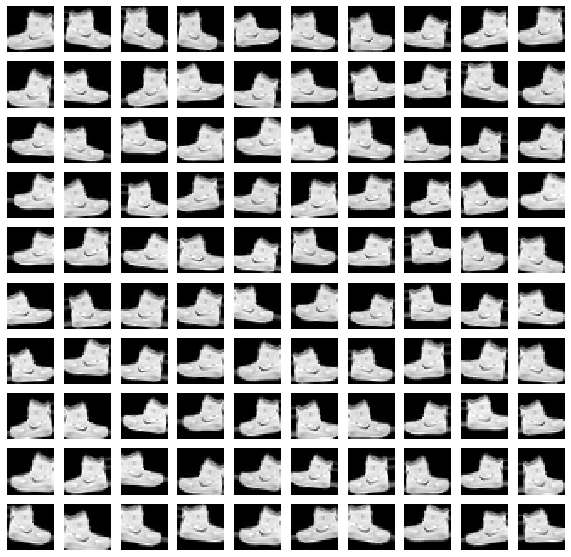

In [12]:
plt.figure(figsize=(10, 10))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.axis('off')
    plt.imshow(x_augmented[i].reshape(28, 28), cmap='gray')
plt.show()

#### 훈련 데이터 이미지 보강 
* 훈련 데이터 이미지 보강을 위해 다량의 이미지를 생성하고 학습을 위해 훈련 데이터에 추가 
* np.random.choice(60000, size=30000,replace=False) : 중복되지 않은 3만개의 숫자 추출 
* 원본의 변형을 막기 위해 copy() 사용 
* flow() : 3만 개의 새로운 이미지 생성 
* np.concatenate((train_X, x_augmented)) : train_X에 x_augmented 만큼 추가해서 9만개의 이미지 생성  

In [16]:
image_generator = ImageDataGenerator(
    rotation_range = 10, 
    zoom_range=0.10, 
    shear_range=0.5,
    width_shift_range=0.10,
    height_shift_range=0.10, 
    horizontal_flip=True,
    vertical_flip=False
)

augment_size = 30000  # 증가시킬 이미지 갯수 

# 임의의 30000 개 인덱스 추출 
randidx = np.random.choice(train_X.shape[0], size=augment_size, replace=False)

# 복사본 생성 
x_augmented = train_X[randidx].copy()
y_augmented = train_Y[randidx].copy()

x_augmented = image_generator.flow(x_augmented, np.zeros(augment_size), batch_size = augment_size, shuffle=False).next()[0]

# 원래 데이터인 x_train 에 Image Augmentation 된 x_augmented 를 추가합니다.
train_X = np.concatenate((train_X, x_augmented))   # 3만개의 새로운 이미지 추가 
train_Y = np.concatenate((train_Y, y_augmented))

print(train_X.shape)

(90000, 28, 28, 1)


#### VGGNet style 네트워크 + Image Augmentation 학습
* padding='valid' : 컨볼루션 연산 전에 입력 이미지 주변에 빈 값을 넣을지 지정하는 옵셥(valid/same)으로 'valid'는 빈 값을 사용하지 않는다. 'same'은 빈 값을 넣어 같은 크기의 이미지를 출력

In [17]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(input_shape=(28,28,1), kernel_size=(3,3), filters=32, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'),
    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=256, padding='valid', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Flatten(),   # 평단화 
    
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')  # 10개 판단 
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0

#### 모델 컴파일 & 학습

In [19]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_X, train_Y, epochs=25, validation_split=0.25)

Train on 67500 samples, validate on 22500 samples
Epoch 1/25
67500/67500 [==============================] - 33s 492us/sample - loss: 0.5751 - accuracy: 0.7889 - val_loss: 0.5848 - val_accuracy: 0.7720
Epoch 2/25
67500/67500 [==============================] - 30s 444us/sample - loss: 0.3855 - accuracy: 0.8608 - val_loss: 0.5251 - val_accuracy: 0.8008
Epoch 3/25
67500/67500 [==============================] - 30s 445us/sample - loss: 0.3418 - accuracy: 0.8771 - val_loss: 0.4892 - val_accuracy: 0.8108
Epoch 4/25
67500/67500 [==============================] - 30s 445us/sample - loss: 0.3168 - accuracy: 0.8844 - val_loss: 0.4270 - val_accuracy: 0.8382
Epoch 5/25
67500/67500 [==============================] - 30s 445us/sample - loss: 0.3080 - accuracy: 0.8899 - val_loss: 0.4235 - val_accuracy: 0.8416
Epoch 6/25
67500/67500 [==============================] - 30s 446us/sample - loss: 0.2948 - accuracy: 0.8931 - val_loss: 0.4152 - val_accuracy: 0.8424
Epoch 7/25
67500/67500 [====================

In [21]:
model.evaluate(test_X, test_Y, verbose=1)

10000/10000 [==============================] - 1s 143us/sample - loss: 0.2224 - accuracy: 0.9222


[0.2224241581082344, 0.9222]

#### 그래프로 출력 

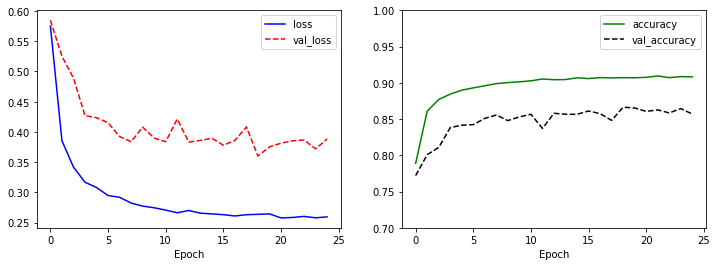

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()
plt.show()